In [1]:
import pickle, time, re
from collections import OrderedDict
from tabulate import tabulate

# import helpers

import numpy as np
from numpy.random import seed

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from matplotlib import pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set_style('darkgrid')

# ignore warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import shap

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# fixate the random state for reproducability
RANDOM_STATE = 1337
seed(RANDOM_STATE)

In [3]:
# read in complete labeled data set
df = pd.read_csv('../datasets/PowerShellCorpus.ast.csv')

# split into target variable and input features
paths = df.Path
y = df.Label
X = df.drop( ['Path', 'Label'], axis=1)

# preserve the path in case we need it
X_path = df.drop( ['Label'], axis=1)
X_train_path, X_test_path, y_train, y_test = train_test_split(X_path, y, test_size=0.2, random_state=RANDOM_STATE)

# split off 20% of the data for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [4]:
boruta_shap_accepted_features = ['AstCmdletMetrics_CharacterDistribution_&_26_Percent', 'AstMemberArgumentMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_m_6d_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_{_7b_Count', 'AstGroupedBinaryExpressionOperators_Plus_Count', 'AstGroupedAstTypes_StatementBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_UpperAlphaPercent_Average', 'LineByLineMetrics_CharacterDistribution_(_28_Percent', 'LineByLineMetrics_CharacterDistribution_A_41_Percent', 'AstGroupedBinaryExpressionOperators_Format_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_Length_Median', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstCmdletMetrics_UpperAlphaPercent_Mode', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Count', 'AstVariableNameMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_R_52_Count', 'AstCmdletMetrics_CharacterDistribution_n_6e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Count', 'AstTypeExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Percent', 'AstCmdletMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_CharacterDistribution_n_6e_Percent', 'AstGroupedAstTypes_TypeConstraintAst_Count', 'AstStringMetrics_Entropy_Average', 'AstCmdletMetrics_CharacterDistribution_u_75_Percent', 'AstVariableNameMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_d_64_Percent', 'AstStringMetrics_Length_Average', 'AstVariableNameMetrics_CharacterDistribution_1_31_Percent', 'AstCmdletMetrics_CharacterDistribution_j_6a_Count', 'AstCmdletMetrics_CharacterDistribution_u_75_Count', 'AstGroupedBinaryExpressionOperators_Format_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Average', 'LineByLineMetrics_Length_Mode', 'AstMemberMetrics_Entropy_Maximum', 'LineByLineMetrics_CharacterDistribution_#_23_Percent', 'LineByLineMetrics_CharacterDistribution_e_65_Percent', 'AstCmdletMetrics_CharacterDistribution_-_2d_Count', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_E_45_Percent', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Average', 'AstMemberArgumentMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Percent', 'AstGroupedAstTypes_AttributeAst_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Count', 'LineByLineMetrics_CharacterDistribution_Y_59_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Count', 'AstMemberMetrics_CharacterDistribution_{_7b_Count', 'AstCmdletMetrics_CharacterDistribution_`_60_Count', 'AstVariableNameMetrics_CharacterDistribution_`_60_Percent', 'LineByLineMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberMetrics_CharacterDistribution_(_28_Percent', 'AstStringMetrics_Length_Median', 'AstCmdletMetrics_CharacterDistribution_o_6f_Count', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Count', 'AstMemberMetrics_Entropy_Median', 'AstMemberArgumentMetrics_UpperAlphaPercent_Mode', 'AstInvocationOperatorInvokedObjectMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Minimum', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstMemberMetrics_CharacterDistribution_}_7d_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_x_78_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Mode', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Count", 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Count', 'AstStringMetrics_CharacterDistribution_Q_51_Count', "LineByLineMetrics_CharacterDistribution_'_27_Percent", 'AstArrayElementMetrics_UpperAlphaPercent_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_Length_Total', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Maximum', 'AstTypeExpressionMetrics_CharacterDistribution_B_42_Percent', 'AstGroupedAstTypes_IfStatementAst_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Count', 'AstCmdletMetrics_CharacterDistribution_._2e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Mode', 'AstConvertExpressionMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_i_69_Percent', 'AstVariableNameMetrics_Entropy_Range', "AstArrayElementMetrics_CharacterDistribution_'_27_Count", 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Count', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Count', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstCommentMetrics_Entropy_Average', 'AstStringMetrics_CharacterDistribution_Q_51_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Count', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_Entropy_Maximum', 'AstVariableNameMetrics_CharacterDistribution_m_6d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Count', 'AstVariableNameMetrics_Entropy_Average', 'AstGroupedAstTypes_StringConstantExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution__22_Count"', 'AstCmdletMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberArgumentMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Entropy_Average', 'AstCmdletMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_Length_Total', 'AstTypeConstraintMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Mode', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Count', 'LineByLineMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Count', 'LineByLineMetrics_CharacterDistribution_w_77_Percent', 'LineByLineMetrics_CharacterDistribution_V_56_Percent', 'LineByLineMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Count', 'AstMemberArgumentMetrics_CharacterDistribution_E_45_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Count', 'AstCmdletMetrics_Entropy_Mode', 'AstTypeConstraintMetrics_CharacterDistribution_R_52_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Percent', 'AstMemberMetrics_CharacterDistribution_`_60_Count', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstStringMetrics_Length_Mode', 'AstStringMetrics_Density_Average', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Count', 'AstMemberArgumentMetrics_Entropy_Maximum', 'AstMemberMetrics_CharacterDistribution_{_7b_Percent', 'AstGroupedAstTypes_ParameterAst_Percent', 'AstCmdletMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_E_45_Count', 'AstTypeConstraintMetrics_Count', 'AstCommentMetrics_Density_Median', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Percent', 'AstGroupedAstTypes_ArrayLiteralAst_Percent', 'LineByLineMetrics_CharacterDistribution_h_68_Percent', 'AstMemberArgumentMetrics_Entropy_Average', 'AstFunctionNameMetrics_UpperAlphaPercent_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Count', 'LineByLineMetrics_CharacterDistribution_,_2c_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Count', 'AstFunctionNameMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_[_5b_Count', 'AstStringMetrics_CharacterDistribution_Z_5a_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Percent', 'AstCmdletMetrics_CharacterDistribution_e_65_Count', 'AstCmdletMetrics_UpperAlphaPercent_Minimum', 'LineByLineMetrics_Entropy_Median', 'AstTypeConstraintMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Percent', 'AstConvertExpressionMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_[_5b_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Percent', 'LineByLineMetrics_Count', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Count', 'AstConvertExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Count', 'AstVariableNameMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution__22_Percent"', 'AstCmdletMetrics_Length_Minimum', 'LineByLineMetrics_Density_Maximum', 'AstCmdletMetrics_Length_Median', 'AstStringMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_AttributeAst_Count', 'LineByLineMetrics_CharacterDistribution_$_24_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Count', 'AstStringMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_CommandAst_Percent', 'AstCmdletMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution_u_75_Percent', 'AstCmdletMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Percent', 'AstCommentMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_r_72_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Count', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Count', 'AstMemberMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Count', 'AstStringMetrics_Entropy_Minimum', 'AstCmdletMetrics_UpperAlphaPercent_Median', 'AstStringMetrics_CharacterDistribution_}_7d_Count', 'AstMemberMetrics_CharacterDistribution_4_34_Count', 'AstArrayElementMetrics_CharacterDistribution_A_41_Count', 'AstTypeConstraintMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_e_65_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Count', 'AstGroupedAstTypes_PipelineAst_Percent', 'AstCommentMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_CharacterDistribution_G_47_Percent', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Percent', 'AstGroupedAstTypes_VariableExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Count', 'AstVariableNameMetrics_Length_Median', "AstArrayElementMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Range', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Percent', 'LineByLineMetrics_CharacterDistribution_Y_59_Percent', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstVariableNameMetrics_CharacterDistribution_s_73_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Count', 'LineByLineMetrics_Length_Average', 'AstStringMetrics_CharacterDistribution_1_31_Count', 'AstCmdletMetrics_Entropy_Median', 'AstMemberMetrics_CharacterDistribution_t_74_Percent', "LineByLineMetrics_CharacterDistribution_'_27_Count", 'AstGroupedAstTypes_ParameterAst_Count', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Minimum', 'AstMemberMetrics_CharacterDistribution_`_60_Percent', 'AstVariableNameMetrics_CharacterDistribution_t_74_Percent', 'AstMemberMetrics_CharacterDistribution__22_Percent"', 'AstFunctionNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_Entropy_Average', 'AstGroupedAstTypes_NamedBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_\\_5c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_J_4a_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_,_2c_Percent', 'AstVariableNameMetrics_CharacterDistribution_e_65_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Count', 'AstStringMetrics_Entropy_Median', 'AstVariableNameMetrics_CharacterDistribution_a_61_Percent', 'AstStringMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Percent', 'AstCmdletMetrics_CharacterDistribution_T_54_Percent', 'AstCmdletMetrics_CharacterDistribution_I_49_Percent', 'AstVariableNameMetrics_CharacterDistribution_E_45_Percent', 'AstCmdletMetrics_UpperAlphaPercent_Maximum', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Median', 'AstFunctionNameMetrics_UpperAlphaPercent_Average', 'AstGroupedAstTypes_BinaryExpressionAst_Count', 'AstGroupedBinaryExpressionOperators_And_Percent', 'LineByLineMetrics_CharacterDistribution_CR_0D_Count', 'LineByLineMetrics_CharacterDistribution_r_72_Percent', 'AstMemberMetrics_UpperAlphaPercent_Average', 'AstTypeConstraintMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_CharacterDistribution_s_73_Count', 'LineByLineMetrics_Entropy_Maximum', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Count", 'AstCommentMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Average', 'AstStringMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Percent', 'AstCmdletMetrics_CharacterDistribution_`_60_Percent', 'AstFunctionNameMetrics_UpperAlphaPercent_Maximum', 'AstTypeConstraintMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_c_63_Percent', 'AstMemberMetrics_UpperAlphaPercent_Minimum', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Percent", 'AstVariableNameMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Median', 'AstMemberArgumentMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_CharacterDistribution_G_47_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_Length_Total', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Count', 'AstGroupedAssignmentStatements_Equals_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Percent', 'AstStringMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_j_6a_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_UpperAlphaPercent_Average', 'AstVariableNameMetrics_CharacterDistribution_s_73_Count', 'AstInvocationOperatorInvokedObjectMetrics_Density_Median', 'AstVariableNameMetrics_CharacterDistribution_i_69_Percent', 'LineByLineMetrics_CharacterDistribution_]_5d_Count', 'AstTypeExpressionMetrics_CharacterDistribution_E_45_Percent', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'LineByLineMetrics_Density_Average', 'AstMemberMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Count', 'AstTypeExpressionMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Median', 'AstCmdletMetrics_CharacterDistribution_c_63_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Count', 'AstCmdletMetrics_CharacterDistribution_r_72_Count', 'AstVariableNameMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_CR_0D_Percent', 'LineByLineMetrics_CharacterDistribution_0_30_Percent', 'AstStringMetrics_CharacterDistribution_0_30_Count', 'AstMemberMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_Q_51_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_R_52_Percent', 'AstMemberMetrics_CharacterDistribution_i_69_Percent', 'AstIntegerAndDoubleMetrics_CharacterDistribution_9_39_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_4_34_Percent', 'LineByLineMetrics_Length_Total', 'AstCmdletMetrics_Entropy_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_CharacterDistribution_}_7d_Percent', 'AstVariableNameMetrics_CharacterDistribution_a_61_Count', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Percent', 'LineByLineMetrics_CharacterDistribution_4_34_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Percent', 'AstCmdletMetrics_CharacterDistribution_n_6e_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Count', 'AstTypeConstraintMetrics_CharacterDistribution_g_67_Count', 'AstTypeConstraintMetrics_CharacterDistribution_t_74_Count', 'AstGroupedAstTypes_ScriptBlockAst_Percent', 'AstCommentMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_CharacterDistribution_=_3d_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Percent', 'AstCmdletMetrics_CharacterDistribution_B_42_Percent', 'AstStringMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_|_7c_Percent', 'AstGroupedBinaryExpressionOperators_Ieq_Percent', 'LineByLineMetrics_Entropy_Average', 'AstMemberArgumentMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_{_7b_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Length_Maximum', 'AstCommentMetrics_Entropy_Range', 'AstStringMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_Entropy_Maximum', 'AstGroupedBinaryExpressionOperators_Plus_Percent', 'LineByLineMetrics_CharacterDistribution_1_31_Count', 'AstVariableNameMetrics_CharacterDistribution_{_7b_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_n_6e_Count', 'LineByLineMetrics_CharacterDistribution_6_36_Percent', 'AstVariableNameMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_}_7d_Count', 'LineByLineMetrics_CharacterDistribution_e_65_Count', 'AstCommentMetrics_Density_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_Entropy_Mode', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Percent', 'LineByLineMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_F_46_Count', 'LineByLineMetrics_CharacterDistribution_l_6c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Count', 'AstVariableNameMetrics_CharacterDistribution_t_74_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_g_67_Count', 'AstGroupedAstTypes_BinaryExpressionAst_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Mode', 'AstMemberMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_c_63_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Count', 'LineByLineMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_A_41_Percent', 'AstMemberMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_[_5b_Count', 'LineByLineMetrics_CharacterDistribution_n_6e_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstGroupedAstTypes_CommandExpressionAst_Percent', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'LineByLineMetrics_CharacterDistribution_A_41_Count', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Count', 'AstGroupedAstTypes_VariableExpressionAst_Count', 'AstGroupedAstTypes_CommandParameterAst_Percent', 'AstCommentMetrics_Length_Average', 'LineByLineMetrics_UpperAlphaPercent_Median', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Percent', 'AstGroupedAstTypes_StringConstantExpressionAst_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Percent', 'AstCommentMetrics_Density_Average', 'AstMemberArgumentMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Percent', 'AstVariableNameMetrics_CharacterDistribution_`_60_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Percent', 'AstCmdletMetrics_Length_Range', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Count', 'LineByLineMetrics_CharacterDistribution_1_31_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Count', 'LineByLineMetrics_Length_Range', 'AstStringMetrics_Count', 'AstStringMetrics_Length_Minimum', 'LineByLineMetrics_CharacterDistribution_4_34_Percent', 'AstMemberMetrics_CharacterDistribution_y_79_Percent', 'AstVariableNameMetrics_Length_Average', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Percent', 'AstVariableNameMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_O_4f_Percent', 'AstStringMetrics_CharacterDistribution_1_31_Percent', 'LineByLineMetrics_CharacterDistribution__22_Count"', 'AstFunctionNameMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_CharacterDistribution_\\_5c_Percent', 'AstVariableNameMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Count', 'AstMemberArgumentMetrics_CharacterDistribution_H_48_Count', 'AstStringMetrics_Entropy_Range', 'LineByLineMetrics_CharacterDistribution_]_5d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Average', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Percent', 'AstStringMetrics_Length_Maximum', 'AstCommentMetrics_Density_Range', 'LineByLineMetrics_Density_Median', 'AstStringMetrics_CharacterDistribution_4_34_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Total', 'AstVariableNameMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Count', 'AstTypeConstraintMetrics_CharacterDistribution_S_53_Count', 'AstStringMetrics_CharacterDistribution__22_Percent"', 'AstGroupedAstTypes_ParamBlockAst_Count', 'LineByLineMetrics_CharacterDistribution_E_45_Count', 'AstCommentMetrics_Density_Maximum']
print(f"Number of features selected from Boruta-Shap: {len(boruta_shap_accepted_features)}")
X_boruta_shap = X[boruta_shap_accepted_features]
X_train_boruta_shap = X_train[boruta_shap_accepted_features]
X_test_boruta_shap = X_test[boruta_shap_accepted_features]

# remove "Json" style named features for some of the boosted algorithms that don't like the feature names
X_boruta_shap = X_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train_boruta_shap = X_train_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_boruta_shap = X_test_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

Number of features selected from Boruta-Shap: 446


# Evading the Neural Network

**Note:** Since Neural Networks don't have implicit feature importances like Logistic Regression or tree-based algorithms, we're going to have to use SHAP values exclusively for evaluation.

In [5]:
# recreate our neural network architecture and load the tuned model weights

layers  = 4
neurons = 192
dropout = 0.5

model = Sequential()
model.add(Dense(neurons, input_dim=X_boruta_shap.shape[1], activation='relu'))
model.add(Dropout(dropout))
    
for i in range(layers-1):
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout))

model.add(Dense(1, activation='sigmoid'))
model.load_weights(f"../models/neural_network/tuned_{layers}_{neurons}_{dropout}.ckpt")

In [6]:
# rebuild our scaler
scaler = MinMaxScaler()
scaler.fit(X_train_boruta_shap)
X_train_boruta_shap_scaled = scaler.transform(X_train_boruta_shap)
X_test_boruta_shap_scaled = scaler.transform(X_test_boruta_shap)

In [7]:
# ref - https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16

t = time.time()

num_samples = 5000

explainer = shap.DeepExplainer(model, X_train_boruta_shap_scaled[0:num_samples])

shap_values = explainer.shap_values(X_test_boruta_shap_scaled)

print(f"Shapley values calculated in : {time.time() - t}")

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


Shapley values calculated in : 414.132648229599


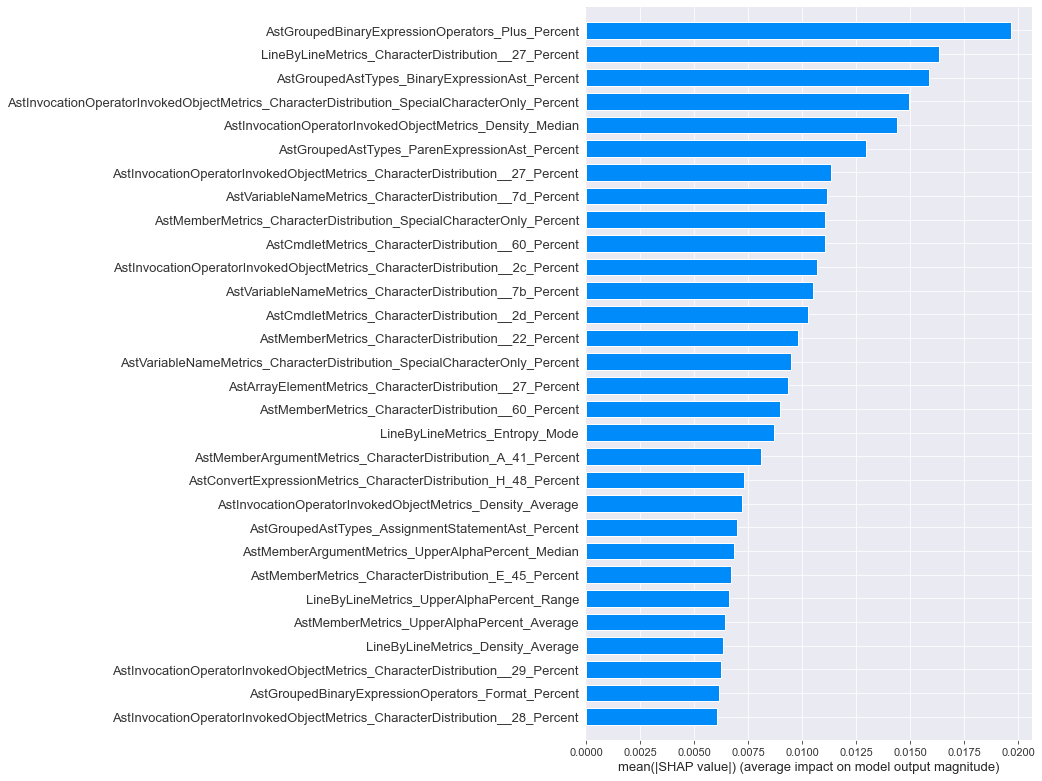

In [8]:
# Display the most incluential features over the test set
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names=X_test_boruta_shap.columns, max_display=30)

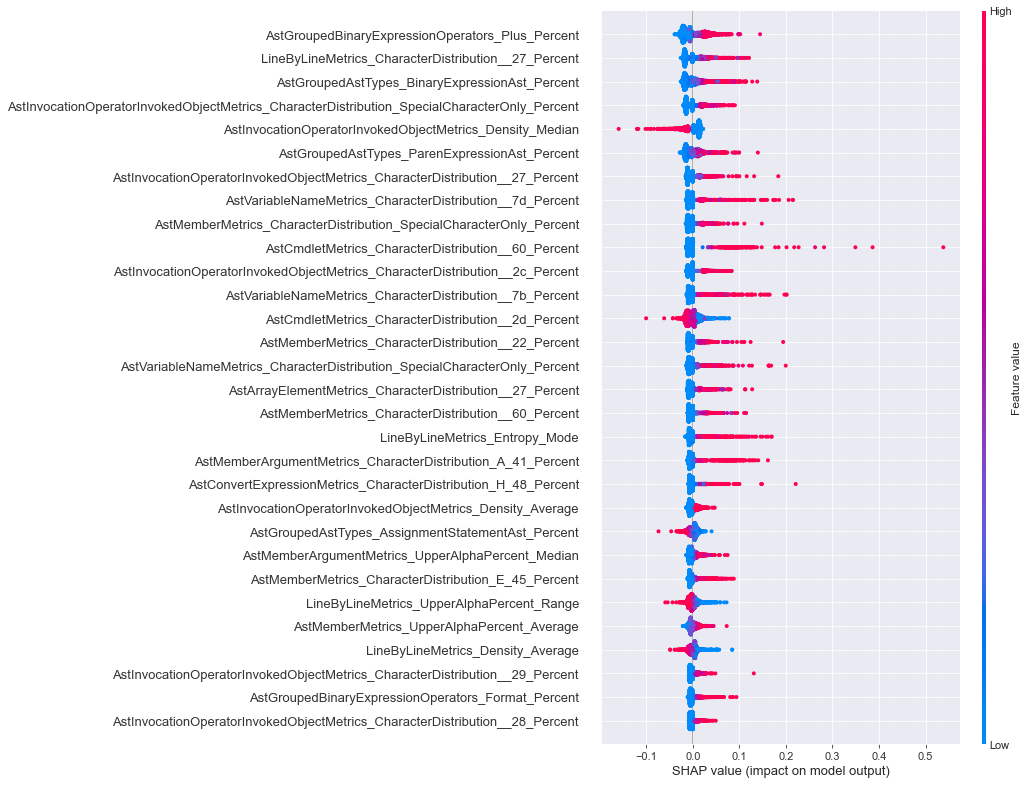

In [9]:
# Display the most incluential features over the test set including in which direction each feature influences the decision
shap.summary_plot(shap_values[0], X_test_boruta_shap_scaled, feature_names=X_test_boruta_shap.columns, max_display=30)

In [10]:
# helper to generate SHAP values for a sample and display waterfall and decision plots

def explain_deep_shap_sample(explainer, X_input):
    shap_values = explainer.shap_values(X_input.values)

    print("SHAP waterfall plot")
    display(shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                                   shap_values[0][0,:],
                                                   feature_names = X_input.columns,
                                                   max_display = 20))
    
    print("SHAP decision plot")
    display(shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][0,:], features=X_input.iloc[0,:], feature_names=X_input.columns.tolist()))


# helper that takes a CSV and returns a properly formatted dataframe
def get_sample(csv_name, ret_df = False):
    # read in the ast csv
    df = pd.read_csv(csv_name)

    # split into target variable and input features
    y = df.Label
    X = df.drop( ['Path', 'Label'], axis=1)

    # select just the Boruta-Shap features we want
    X_boruta_shap = X[boruta_shap_accepted_features]

    # remove "Json" style named features for some of the boosted algorithms that don't like the feature names
    X_boruta_shap = X_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    X_boruta_shap_scaled = pd.DataFrame(scaler.transform(X_boruta_shap), columns=X_boruta_shap.columns)

    if ret_df:
        return X_boruta_shap_scaled
    else:
        return X_boruta_shap_scaled.iloc[0]


Original Predicted label : 1.0

SHAP waterfall plot


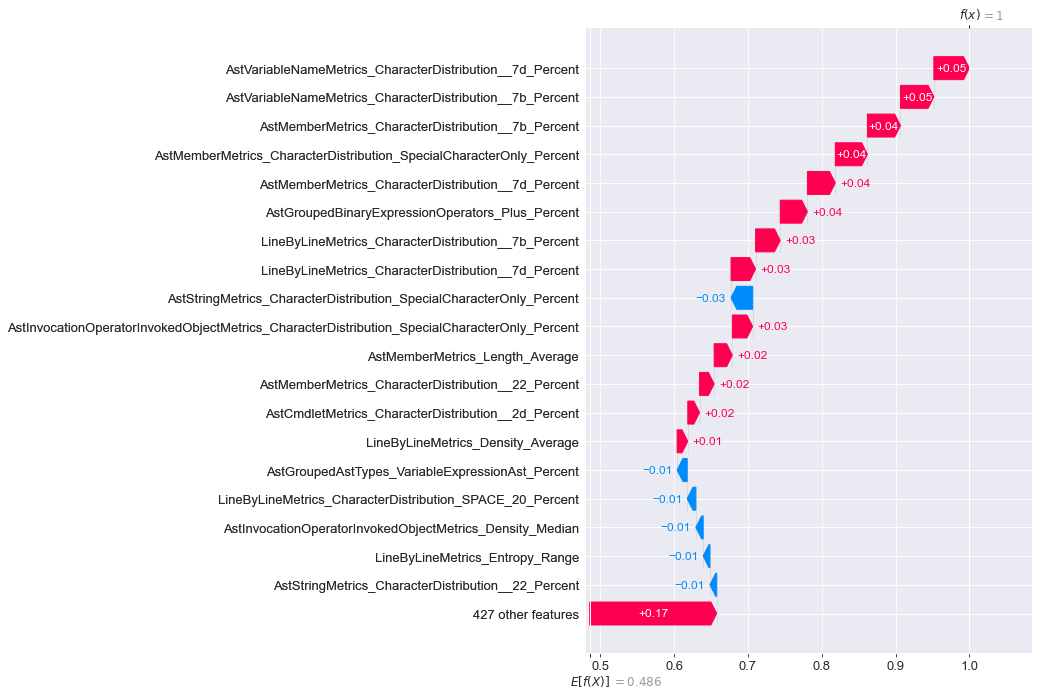

None

SHAP decision plot


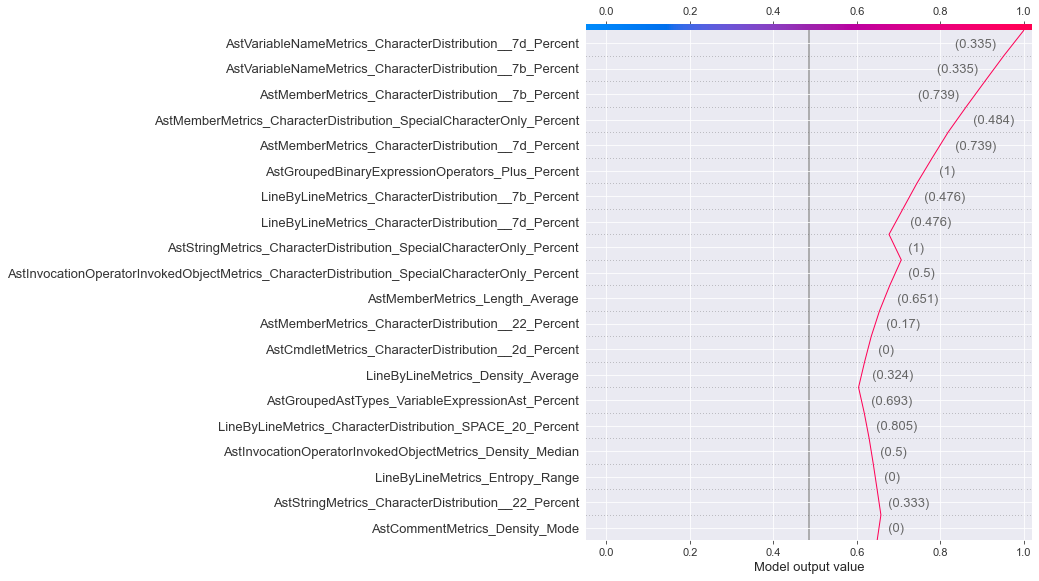

None

In [11]:
# see what the original DBOdemo1.ps1 looks like

X_demo_orig_boruta_shap_scaled = get_sample('../samples/DBOdemo1.ps1.ast.csv', True)

print(f"Original Predicted label : {model.predict(X_demo_orig_boruta_shap_scaled.values.reshape(1, -1))[0][0]}\n")

explain_deep_shap_sample(explainer, X_demo_orig_boruta_shap_scaled)

**Note:**

Repeated iterations were done in the following step, adding additional "normal" features from the global beeswarm graph until the decision boundary was crossed.

The following code, added to the top of **DBOdemo1.ps1**, resulted in flipping the classification to "normal":

<code>
function t--------------------------------------------------a{}
t--------------------------------------------------a
$a.yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy
...rest of DBOdemo.ps1...
</code>

Original Predicted label : 0.2601853013038635

SHAP waterfall plot


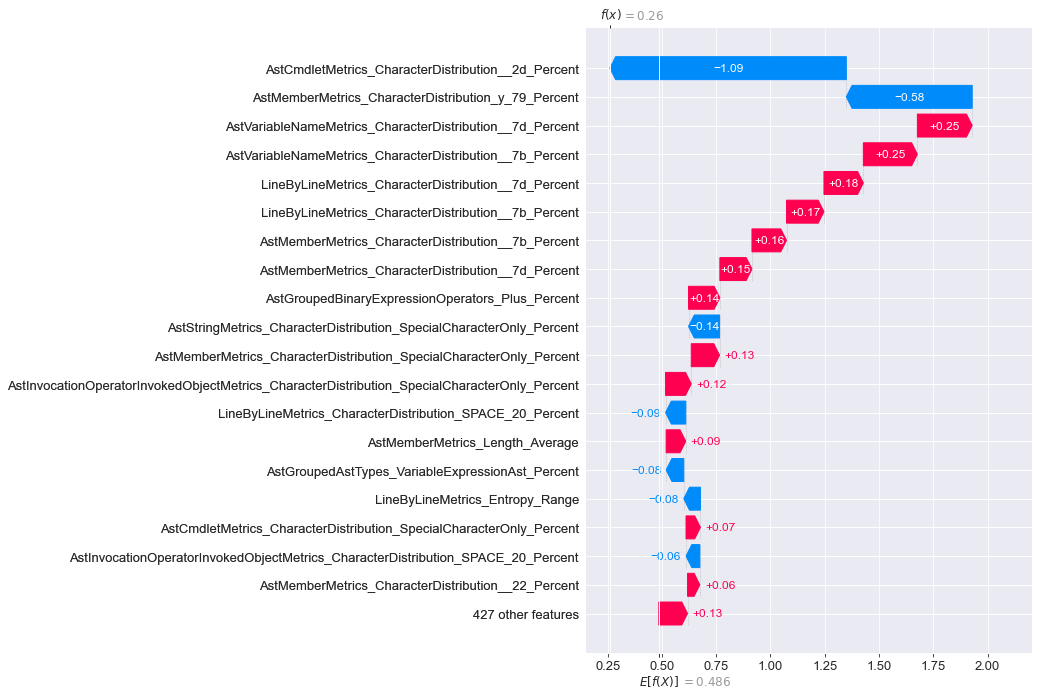

None

SHAP decision plot


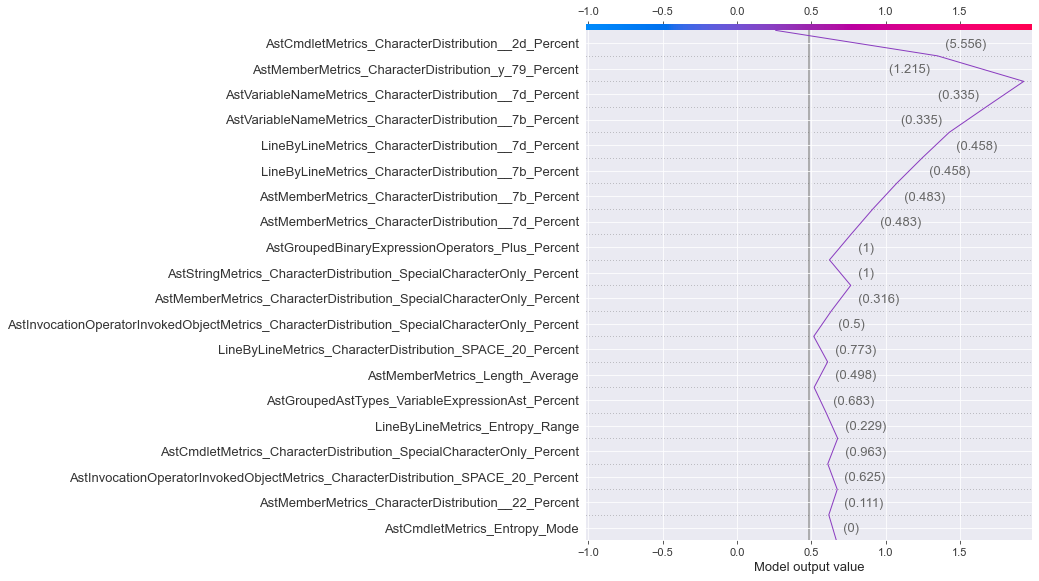

None

In [12]:
X_demo_orig_boruta_shap_scaled = get_sample('../samples/DBOdemo1_nn.ps1.ast.csv', True)

print(f"Original Predicted label : {model.predict(X_demo_orig_boruta_shap_scaled.values.reshape(1, -1))[0][0]}\n")

explain_deep_shap_sample(explainer, X_demo_orig_boruta_shap_scaled)

**Success! We moved the output to under .5, meaning this model will now classify this sample as "normal".**